# Polynomial Fitting

Similarly to the transit model we can instead fit our data with a polynomial model. 

In [44]:
from chromatic_fitting import *
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter

plt.matplotlib.style.use('default')

First we'll create a Rainbow object from chromatic and then add a wavelength-dependent polynomial model:

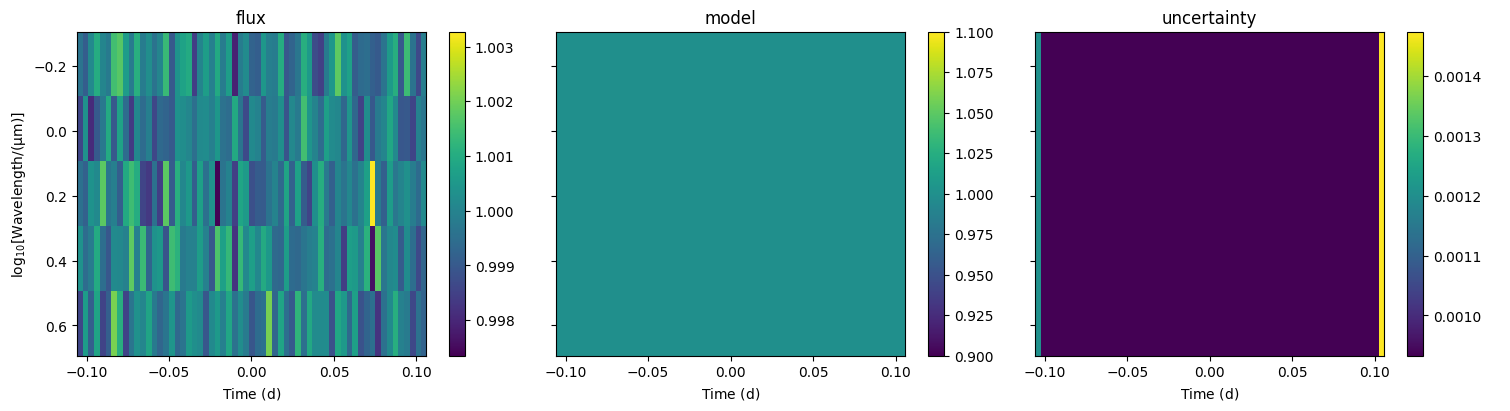

In [45]:
# create simulated rainbow
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)
# bin:
rbin5 = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)

rbin5.imshow_quantities();

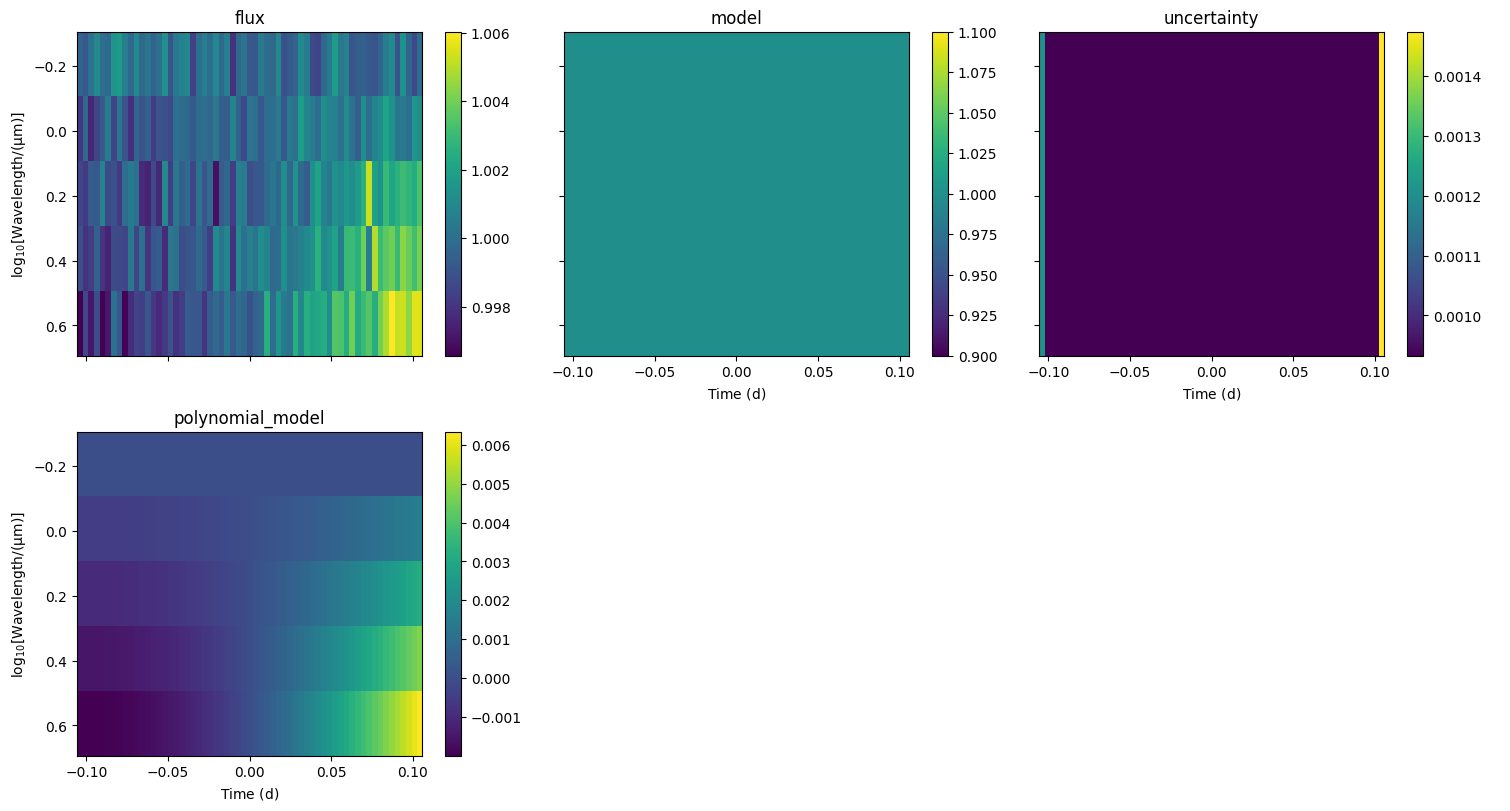

In [46]:
# create wavelength-dep linear + constant model:
poly = [(0.05*i*(rbin5.time.to_value("day")**2)) + (0.01*i*rbin5.time.to_value("day")) for i in range(rbin5.nwave)]

# add this model to the Rainbow
rp = rbin5._create_copy()
rp.flux = rp.flux + poly
rp.fluxlike['polynomial_model'] = np.array(poly)
rp.imshow_quantities()

We set up the `PolynomialModel` similarly to the `TransitModel`, however, we need to provide the `degree` of the polynomial. By setting this argument we can fix some of our degrees to zero. For example if we have a linear model but we want a zero constant offset we could ignore the `p_0` parameter which would be fixed by default to 0. 

We need to be careful (in this version!) with the baseline in the transit model and a constant term in the
polynomial model - we don't want to have 2 fitted offset terms!

In [47]:
# set up polynomial model:
b = PolynomialModel(degree=2)
b.initialize_empty_model()
b.setup_parameters(
    p_0 = 1.0,
    p_1 = WavelikeFitted(Uniform,testval=0.01,upper=1,lower=0),
    p_2 = WavelikeFitted(Uniform,testval=0.01,upper=1,lower=0)
)

# print a summary of all params:
b.summarize_parameters()

polynomial_p_0 =
  <🧮 Fixed | 1.0 🧮>

polynomial_p_1 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=1, lower=0, name='p_1') for each wavelength 🧮>

polynomial_p_2 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=1, lower=0, name='p_2') for each wavelength 🧮>



In [48]:
# setup model the same way as for the transit model!:
b.attach_data(rp)
b.setup_lightcurves()
b.setup_likelihood()

In [49]:
b.pymc3_model

In [50]:
b.sample()
b.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_2_w4, p_1_w4, p_2_w3, p_1_w3, p_2_w2, p_1_w2, p_2_w1, p_1_w1, p_2_w0, p_1_w0]



🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppfSampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.9667662007937179, but should be close to 0.9. Try to increase the number of tuning steps.

🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars

                       mean        sd        hdi_3%   hdi_97%  mcse_mean  \
p_1_w0             0.000889  0.000801  5.000000e-07  0.002333   0.000012   
p_2_w0             0.023596  0.016751  1.640000e-05  0.053937   0.000253   
poly_model_w0[0]   1.000163  0.000199  9.998266e-01  1.000570   0.000003   
poly_model_w0[1]   1.000150  0.000188  9.998300e-01  1.000530   0.000003   
poly_model_w0[2]   1.000137  0.000176  9.998361e-01  1.000492   0.000003   
...                     ...       ...           ...       ...        ...   
poly_model_w4[56]  1.004881  0.000275  1.004361e+00  1.005370   0.000004   
poly_model_w4[57]  1.005124  0.000292  1.004567e+00  1.005640   0.000005   
poly_model_w4[58]  1.005371  0.000309  1.004788e+00  1.005925   0.000005   
poly_model_w4[59]  1.005622  0.000327  1.005000e+00  1.006205   0.000005   
poly_model_w4[60]  1.005878  0.000345  1.005233e+00  1.006509   0.000005   

                    mcse_sd     ess_bulk     ess_tail     r_hat  
p_1_w0             0.


🌈 Warning: invalid value encountered in double_scalars


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

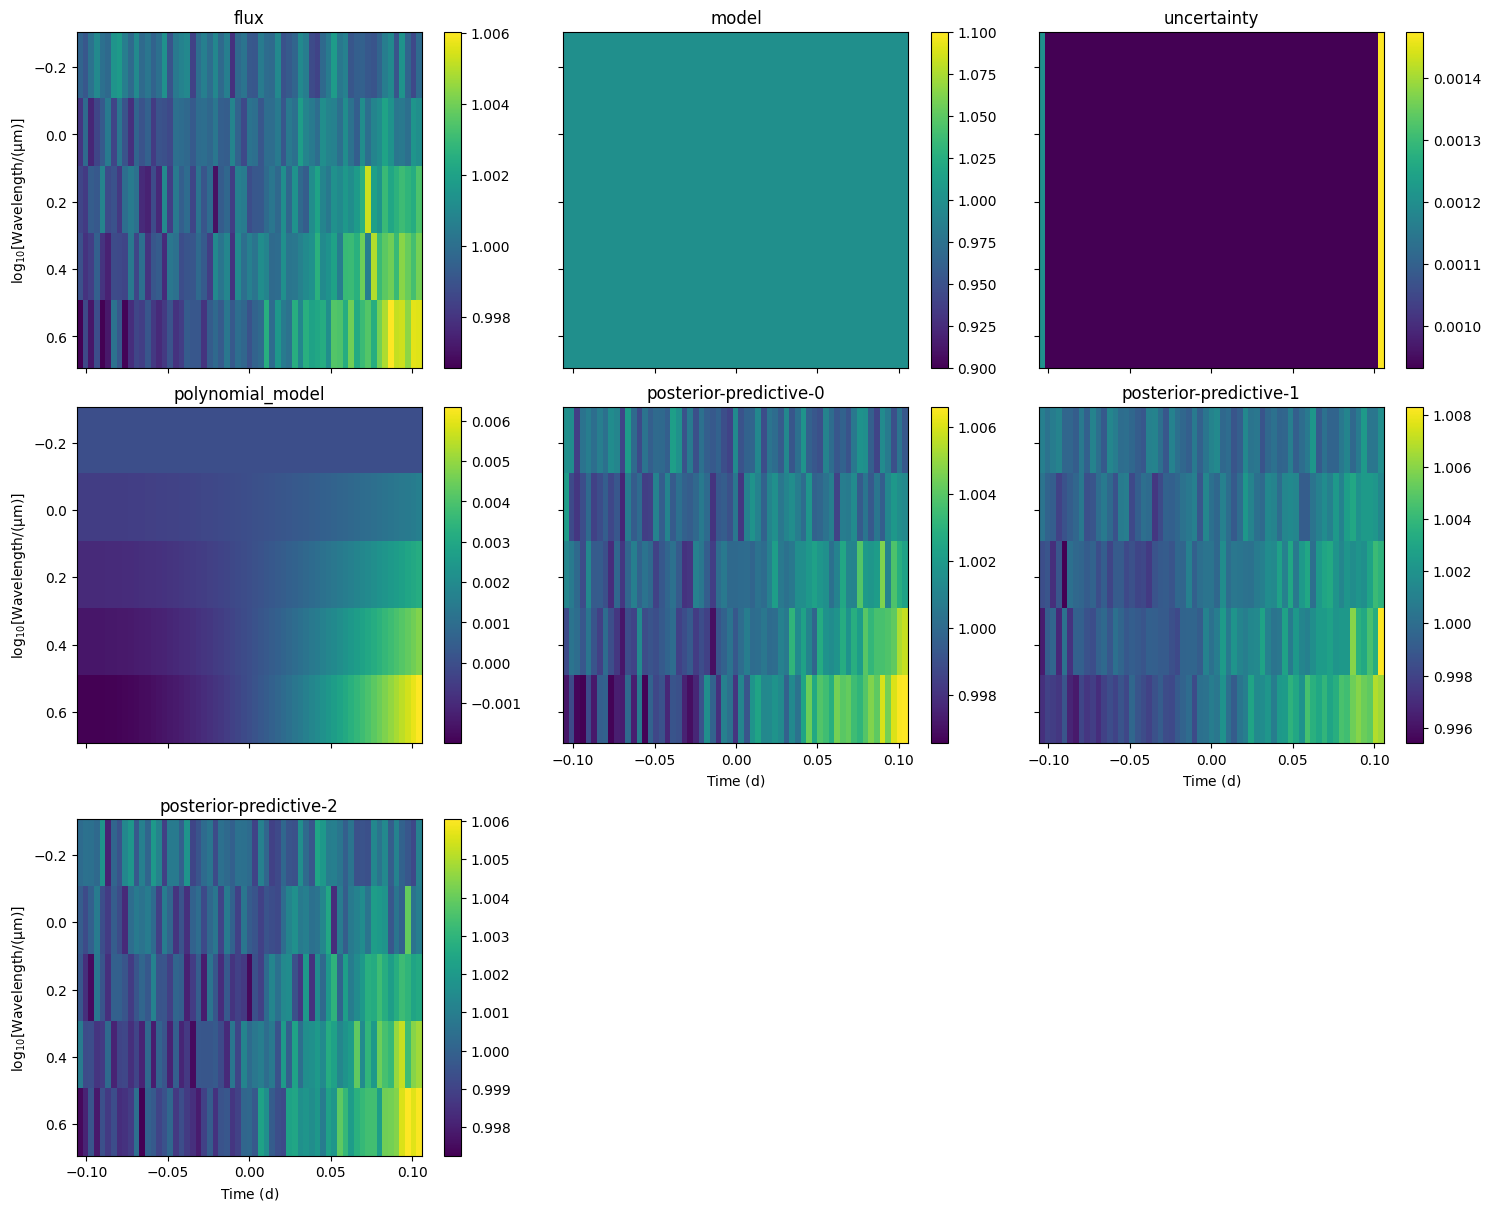

In [51]:
b.plot_posteriors()

### Check residuals
We can always subtract our polynomial model to look at the residuals:

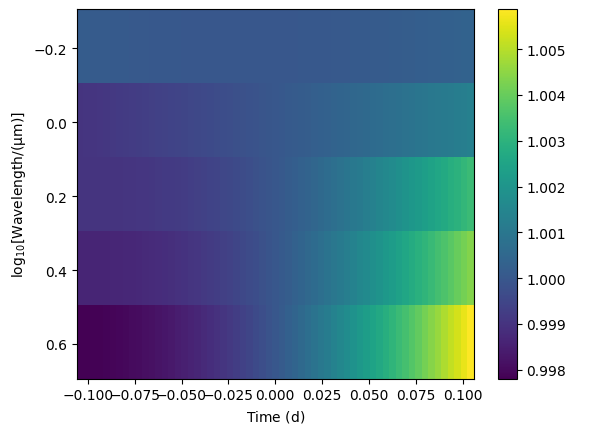

In [52]:
polynomial_model = {}
for w in range(b.data.nwave):
    if f'w{w}' not in polynomial_model.keys():
        polynomial_model[f'w{w}'] = []
    for t in range(b.data.ntime):
        polynomial_model[f'w{w}'].append(b.summary['mean'][f"poly_model_w{w}[{t}]"])
b.data.fluxlike['fit_polynomial_model'] = list(polynomial_model.values())
b.data.imshow(quantity='fit_polynomial_model');

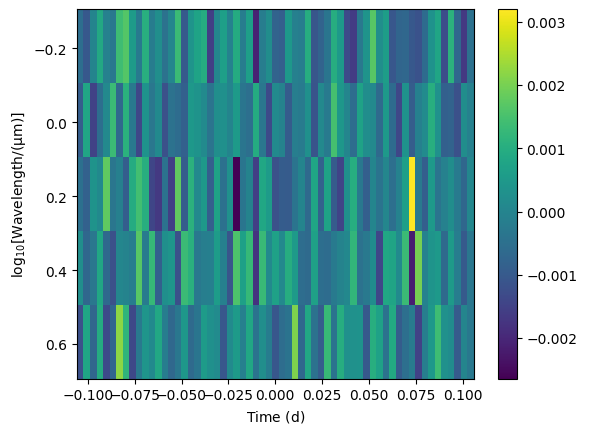

In [55]:
b.data.fluxlike['resid'] = b.data.flux - b.data.fluxlike['fit_polynomial_model']
b.data.imshow(quantity='resid');

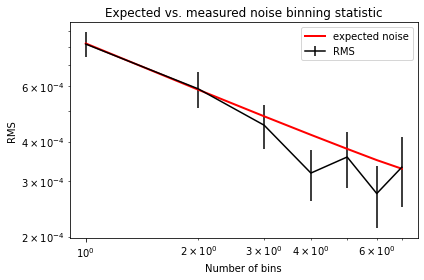

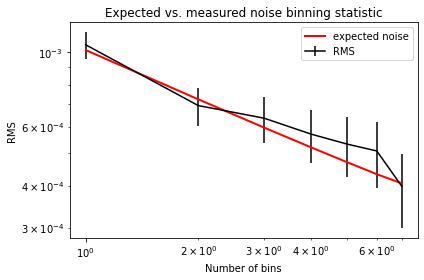

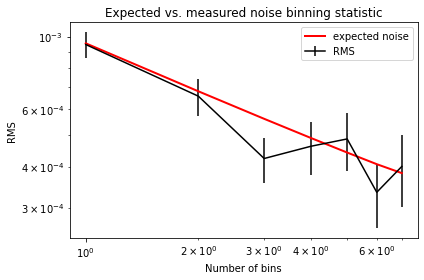

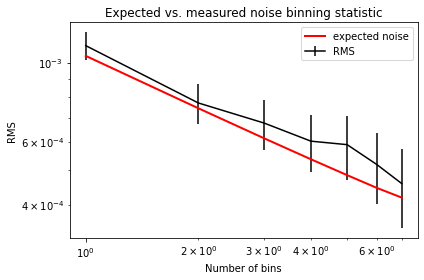

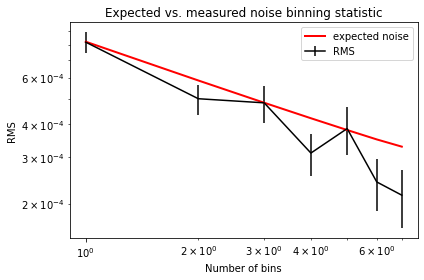

In [14]:
for i in range(5):
    red_noise, white_noise, beta = noise_calculator(b.data.fluxlike['residuals-0'][i])

In [16]:
red_noise, white_noise, beta

(0.000803490843297551, 0.00015819821746630047, 1.2037902632181599)